In [1]:
#importing required library
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def Lasso_Term(P):
    return sum(sum(np.absolute(P)))

In [3]:
def Ridge_Term(P):
    return sum(sum(np.square(P)))

In [65]:
# Calculating Lasso Term for updating parameter
# P -> Feature Matrix of Movie or User
# X -> Similarity Matrix of Movie or User
# i -> Ith Movie or User
# K -> Number of Features
# M -> Number of Movies or User
def IILasso_Term(P,X):
    m = P.shape[0]
    return np.sum(X@abs(P),axis=1).reshape(m,1)*2

In [66]:
# Calculating Lasso Term for updating parameter
# P -> Feature Matrix of Movie or User
# X -> Similarity Matrix of Movie or User
# i -> Ith Movie or User
# K -> Number of Features
# M -> Number of Movies or User
def ULasso_Term(P,X):
    m = P.shape[0]
    return np.sum(X@P,axis=1).reshape(m,1)*2

In [6]:
#Calculating Similarity Matrix for Movies
def calculate_Similarity(X):
    R=X @ X.T
    R=R/len(R)
    return R

In [16]:
def Normal_Lasso_Cost(R,P,Q,mask,lamda=0.02):
    cost=0
    Q=Q.T
    cost = sum(sum((np.square(R - (P @ Q)*mask))))
    cost+=lamda*(Lasso_Term(P)+Lasso_Term(Q.T))
    return cost/len(R) 

In [17]:
def Ridge_Cost(R,P,Q,mask,lamda=0.02):
    cost=0
    Q=Q.T
    cost = sum(sum((np.square(R - (P @ Q)*mask))))
    cost+= lamda*(Ridge_Term(P)+Ridge_Term(Q.T))
    return cost/len(R) 

In [18]:
def New_Lasso_Cost(R,P,Q,Movie_Sim,User_Sim,mask,beta=0.2,lamda=0.02):
    cost=0
    Q=Q.T
    cost = sum(sum((np.square(R - (P @ Q)*mask))))
    cost+=lamda*(Lasso_Term(P)+Lasso_Term(Q.T)+(beta/2)*Lasso_Term((np.absolute(P.T) @ Movie_Sim) @ np.absolute(P)) +(beta/2)*Lasso_Term((np.absolute(Q) @ User_Sim) @ np.absolute(Q.T)))
    return cost/len(R) 

In [19]:
# Function calculating parameters with stochastic gradient descent algorithm with simple lASSO regularization
def matrix_factorization_Lasso(R, P, Q, K,mask, steps=5000, alpha=0.002,lamda=0.02):
    ite=range(steps)
    cost=[]                  
    for step in range(steps): #Number of iterations of stochastic gradient descent
        P = P + alpha * ( 2* ((R - mask * (P @ Q.T)) @ Q)/len(R) - lamda)
        Q = Q + alpha * ( 2 * ((R - mask * (P @ Q.T)).T @ P )/len(R)- lamda)
        cost.append(Normal_Lasso_Cost(R,P,Q,mask))     # Appending cost
    return P,Q,ite,cost

In [25]:
# Function calculating parameters with stochastic gradient descent algorithm with RIDGE regularization
def matrix_factorization_Ridge(R, P, Q, K, mask, steps=5000, alpha=0.002, lamda=0.02):
    ite=range(steps)
    cost=[]
    for step in range(steps): #Number of iteration stochastic gradient descent
        P = P + alpha * ( 2* ((R - mask * (P @ Q.T)) @ Q)/len(R) - lamda * P)
        Q = Q + alpha * ( 2 * ((R - mask * (P @ Q.T)).T @ P )/len(R)- lamda * Q)
        cost.append(Ridge_Cost(R,P,Q,mask))    # Appending Cost
    return P,Q,ite,cost

In [34]:
# Function calculating parameters with stochastic gradient descent algorithm with INDEPENDENTLY INTERPRETABLE lASSO regularization
def matrix_factorization_IILasso(R, P, Q, K, mask, steps=5000, alpha=0.002, beta=0.2,lamda=0.02):
    ite=range(steps)
    cost=[]
    Movie_Sim=calculate_Similarity(R)  #Function for similarity matrix of movies
    User_Sim=calculate_Similarity(R.T)  #Function for similarity matrix of users 
    for step in range(steps):# Number of iteration
        P = P + alpha * ( 2* ((R - mask * (P @ Q.T)) @ Q)/len(R) - lamda  - (beta*(lamda/2)*IILasso_Term(P,Movie_Sim)) )
        Q = Q + alpha * ( 2 * ((R - mask * (P @ Q.T)).T @ P )/len(R)- lamda  -  (beta*(lamda/2)*IILasso_Term(Q,User_Sim)))
        cost.append(New_Lasso_Cost(R,P,Q,Movie_Sim,User_Sim,mask))    # Appending Cost
    return P,Q,ite,cost
    

In [44]:
# Function calculating parameters with stochastic gradient descent algorithm with UNCORRELATED lASSO regularization

def matrix_factorization_ULasso(R, P, Q, K,mask, steps=5000, alpha=0.002, beta=0.2,lamda=0.02):
    ite=range(steps)
    cost=[]
    X1=calculate_Similarity(R)
    Movie_Sim=X1*X1         #Part of ULasso
    X2=calculate_Similarity(R.T)
    User_Sim=X2*X2         #Part of Ulasso
    for step in range(steps):
        P = P + alpha * ( 2* ((R - mask * (P @ Q.T)) @ Q)/len(R) - lamda  - (beta*(lamda/2)*ULasso_Term(P,Movie_Sim)) )
        Q = Q + alpha * ( 2 * ((R - mask * (P @ Q.T)).T @ P )/len(R)- lamda  -  (beta*(lamda/2)*ULasso_Term(Q,User_Sim)))
        cost.append(New_Lasso_Cost(R,P,Q,Movie_Sim,User_Sim,mask))    #Appending Cost
    return P,Q,ite,cost
    

In [13]:
# Function to calculate Squared error
def error(nR,R):
    x=0
    for i in range(len(R)):
        for j in range(len(R[i])):
            if R[i][j] > 0:
                y=R[i][j]-nR[i][j]
                x+=y*y
                
    return math.sqrt(x/len(R))

In [84]:
#Input Matrix of dimension M * N where M represents number of Movies and N represents number of Users
R = [
     [5,3,0,1],
     [4,0,0,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4],
    ]
'''R = [
     [0,4.5,2,0],
     [4,0,3.5,0],
     [0,5,0,2],
     [0,3.5,4,1],
    ]
'''

ratings=pd.read_csv("ratings.csv")
movies=pd.read_csv("movies.csv")
ratings=pd.merge(movies,ratings).drop(['genres','timestamp'],axis=1)
userRatings = ratings.pivot_table(index=['userId'],columns=['title'],values='rating')
userRatings = userRatings.dropna(thresh=100, axis=1).fillna(0,axis=1)
R = np.array(userRatings)  #Converting into numpy array
print(R.shape)
#R=R[0:100]
print(R.shape)
R=R.T
print(R.shape)


R = np.array(R)
M,N=R.shape         # Finding shape of R
K = 2               # Number of Features of movies and users
mask=np.zeros((R.shape))
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        if(R[i,j]>0):
            mask[i,j]=1
P_init = np.random.randn(M,K)  # Initializing Movie's Feature Matrix
Q_init = np.random.randn(N,K) # Initializing User's Feature Matrix

(610, 138)
(610, 138)
(138, 610)


In [85]:

Iter=[] #Initializing Iter List of List for all the model
Cost=[] #Initializing Cost List of List for all the model
print('--------------------------------------Normal Lasso------------------------------------------------')
P=P_init.copy()
Q=Q_init.copy()
nP, nQ , ite, cost = matrix_factorization_Lasso(R, P, Q, K,mask,steps=200)
nR = np.dot(nP, nQ.T)
#print('nP: ',nP)
#print('nQ: ',nQ)
print('nR: ',nR)
print('RME: ',error(nR,R))
Iter.append(ite)
Cost.append(cost)


print('-------------------------------------- RIDGE ------------------------------------------------')
P=P_init.copy()
Q=Q_init.copy()
nP, nQ , ite, cost = matrix_factorization_Ridge(R, P, Q, K,mask,steps=200)
nR = np.dot(nP, nQ.T)
#print('nP: ',nP)
#print('nQ: ',nQ)
print('nR: ',nR)
print('RME: ',error(nR,R))
Iter.append(ite)
Cost.append(cost)

print("\n----------------------------------------ULASSO----------------------------------------------------\n")
P=P_init.copy()
Q=Q_init.copy()
nP, nQ, ite, cost = matrix_factorization_ULasso(R, P, Q, K,mask,steps=200)
nR = np.dot(nP, nQ.T)
#print('nP: ',nP)
#print('nQ: ',nQ)
print('nR: ',nR)
print('RME: ',error(nR,R))
Iter.append(ite)
Cost.append(cost)

print("\n----------------------------------------IILASSO----------------------------------------------------\n")
P=P_init.copy()
Q=Q_init.copy()
nP, nQ, ite, cost = matrix_factorization_IILasso(R, P, Q, K,mask,steps=200)
nR = np.dot(nP, nQ.T)
#print('nP: ',nP)
#print('nQ: ',nQ)
print('nR: ',nR)
print('RME: ',error(nR,R))
Iter.append(ite)
Cost.append(cost)

--------------------------------------Normal Lasso------------------------------------------------
nR:  [[-0.13455029 -2.00788996 -0.25982805 ...  0.676435    0.68694743
  -0.18191886]
 [ 0.24877612 -0.00300936  1.62847749 ...  1.56638364  1.46107074
   0.9106032 ]
 [ 0.12221723  0.35120776  0.6910501  ...  0.50211762  0.45853176
   0.39284643]
 ...
 [ 0.0371081   0.0715706   0.22065428 ...  0.17904089  0.16499673
   0.12469704]
 [ 0.22661916  1.81786968  0.92087809 ...  0.04649214 -0.00736144
   0.54811784]
 [ 0.16551539 -1.32183384  1.49127872 ...  2.04283777  1.9422659
   0.80982716]]
RME:  45.72308965096553
-------------------------------------- RIDGE ------------------------------------------------
nR:  [[-0.11323024 -2.02790747 -0.28536126 ...  0.69258484  0.68519562
  -0.16384697]
 [ 0.23905883 -0.05308657  1.58133594 ...  1.54672935  1.44187115
   0.88514782]
 [ 0.10761507  0.27859298  0.64354532 ...  0.48629419  0.44749743
   0.36082904]
 ...
 [ 0.02983861  0.02409944  0.19043

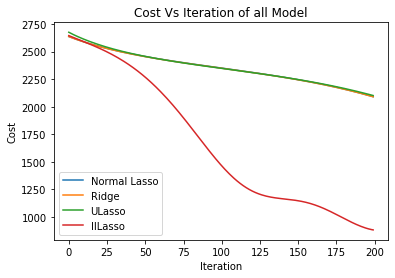

In [86]:
#Visualization of Cost vs Iteration of All the Model

Label=['Normal Lasso' ,'Ridge','ULasso','IILasso']
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Vs Iteration of all Model')
for i in range(4):
    plt.plot(Iter[i],Cost[i],label=Label[i])
    plt.legend()
plt.show()

In [88]:
print(Cost[0][199],Cost[1][199],Cost[2][199],Cost[3][199])

2090.75855307716 2089.788376938844 2101.1843861974958 880.16748542179
